Evaluate the approximation error of spherical harmonics decomposition at a given order, using the figure from Rio *et al.* (2014).

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cartopy.crs as ccrs
import cmocean.cm as cmo
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2lab
import xarray as xr
import xesmf as xe

from src.spherical_harmonics import gen_associated_legendre, sph_harm_y

### 1. Reconstruct 2d $\beta$ and $\theta$ fields from the figure

In [2]:
BLACK_THRESH = 10
NSAMPLES = 1024 * 2


def load_rgb(img):
    pil = Image.open(img)
    arr = jnp.array(pil.convert("RGB"), dtype=jnp.uint8)
    return arr


def sample_colorbar_horizontal(cb_rgb, nsamples=NSAMPLES):
    _, w, _ = cb_rgb.shape
    nsamples = min(nsamples, w)
    idx = jnp.round(jnp.arange(nsamples) / (nsamples - 1) * (w - 1)).astype(int)
    cb_rgb = cb_rgb[:, idx, :]
    return cb_rgb


def get_medoid_columns(img):
    _, w, _ = img.shape
    # Compute pairwise distances along rows for each column
    # Expand dimensions: (H, 1, W, 3) - (1, H, W, 3) -> (H, H, W, 3)
    img1 = img[:, jnp.newaxis, :, :]  # (H, 1, W, 3)
    img2 = img[jnp.newaxis, :, :, :]  # (1, H, W, 3)
    diff = img1 - img2               # (H, H, W, 3)
    dist = jnp.linalg.norm(diff, axis=-1)  # Euclidean in LAB, shape (H, H, W)
    sum_dist = jnp.sum(dist, axis=1)       # sum over all rows, shape (H, W)

    medoid_idx = jnp.argmin(sum_dist, axis=0)  # shape (W,)
    medoid = img[medoid_idx, jnp.arange(w), :]  # (W, 3)

    return medoid


def sanitize_colorbar(samples_rgb):
    samples_rgb = samples_rgb.astype(jnp.float32) / 255.0
    lab_bar = rgb2lab(samples_rgb)

    lab_bar = get_medoid_columns(lab_bar)

    seg_vecs = lab_bar[1:, :] - lab_bar[:-1, :]
    seg_len = jnp.linalg.norm(seg_vecs, axis=-1)

    arc = jnp.nancumsum(jnp.concatenate((jnp.zeros(1), seg_len)))
    arc /= arc[-1]

    return lab_bar, arc, jnp.nanmax(seg_len)


def mask_black(flat_rgb, black_thresh=BLACK_THRESH):
    return jnp.all(flat_rgb <= black_thresh, axis=1)


def project_onto_colorbar(flat_rgb, idx_valid, lab_bar, arc):
    flat_rgb_f = flat_rgb.astype(jnp.float32) / 255.0
    lab_all = rgb2lab(flat_rgb_f.reshape(1, -1, 3)).reshape(-1, 3)

    lab_pixels = lab_all[idx_valid]

    lab_pixels = lab_pixels[:, jnp.newaxis, :]  # (N, 1, 3)
    lab_bar = lab_bar[jnp.newaxis, :, :]        # (1, M, 3)
    diff = lab_pixels - lab_bar                # (N, M, 3)
    dist = jnp.linalg.norm(diff, axis=-1)  # Euclidean in LAB, shape (N, M)
    closest_idx = jnp.argmin(dist, axis=1)  # shape (N,)

    d_min = dist[jnp.arange(len(idx_valid)), closest_idx]
    p_vals = arc[closest_idx]

    return p_vals, d_min


def recover_map_with_coords(
    map_img, colorbar_img, vmin, vmax,
    lon0=0.0, lon1=360.0, lat_top=90.0, lat_bottom=-90.0,
    black_thresh=BLACK_THRESH,
    nsamples=NSAMPLES
):
    map_rgb = load_rgb(map_img)
    cb_rgb = load_rgb(colorbar_img)
    H, W, _ = map_rgb.shape

    samples_rgb = sample_colorbar_horizontal(cb_rgb, nsamples=nsamples)

    lab_bar, arc, max_seg_len = sanitize_colorbar(samples_rgb)

    flat_rgb = map_rgb.reshape(-1, 3).astype(jnp.uint8)
    mask_invalid = mask_black(flat_rgb, black_thresh=black_thresh)
    idx_valid = jnp.where(~mask_invalid)[0]

    p_valid, d_valid = project_onto_colorbar(flat_rgb, idx_valid, lab_bar, arc)

    vals_valid = jnp.full_like(p_valid, jnp.nan)
    good = d_valid <= max_seg_len
    vals_valid = vals_valid.at[good].set(vmin + p_valid[good] * (vmax - vmin))

    out_flat = jnp.full((H * W,), jnp.nan, dtype=float)
    out_flat = out_flat.at[idx_valid].set(vals_valid)

    values = out_flat.reshape(H, W)

    lons = jnp.linspace(lon0, lon1, W, endpoint=True)
    lats = jnp.linspace(lat_top, lat_bottom, H, endpoint=True)

    return values, lons, lats


def to_xarray(values, lons_360, lats, name="parameter", vmin=None, vmax=None):
    lons_180 = ((lons_360 + 180) % 360) - 180

    sort_idx = jnp.argsort(lons_180)
    lons_sorted = lons_180[sort_idx]
    values_sorted = values[:, sort_idx]

    da = xr.DataArray(
        data=np.asarray(values_sorted),
        dims=("lat", "lon"),
        coords={"lat": np.asarray(lats), "lon": np.asarray(lons_sorted)},
        name=name,
        attrs={
            "description": "Recovered from color-mapped image",
            "longitude_convention": "[-180, 180]",
            "vmin": vmin,
            "vmax": vmax,
        }
    )

    return da

In [3]:
beta, lons, lats = recover_map_with_coords(
    "data/rio_2014/beta_map.png", "data/rio_2014/beta_clb.png", vmin=0, vmax=3, lon0=0.5, lon1=359.5
)
beta_da = to_xarray(beta, lons, lats, name="beta", vmin=0, vmax=3)

In [4]:
theta, lons, lats = recover_map_with_coords(
    "data/rio_2014/theta_map.png", "data/rio_2014/theta_clb.png", vmin=-90, vmax=90, lon0=0.5, lon1=359.5
)
theta_da = to_xarray(theta, lons, lats, name="theta", vmin=-90, vmax=90)

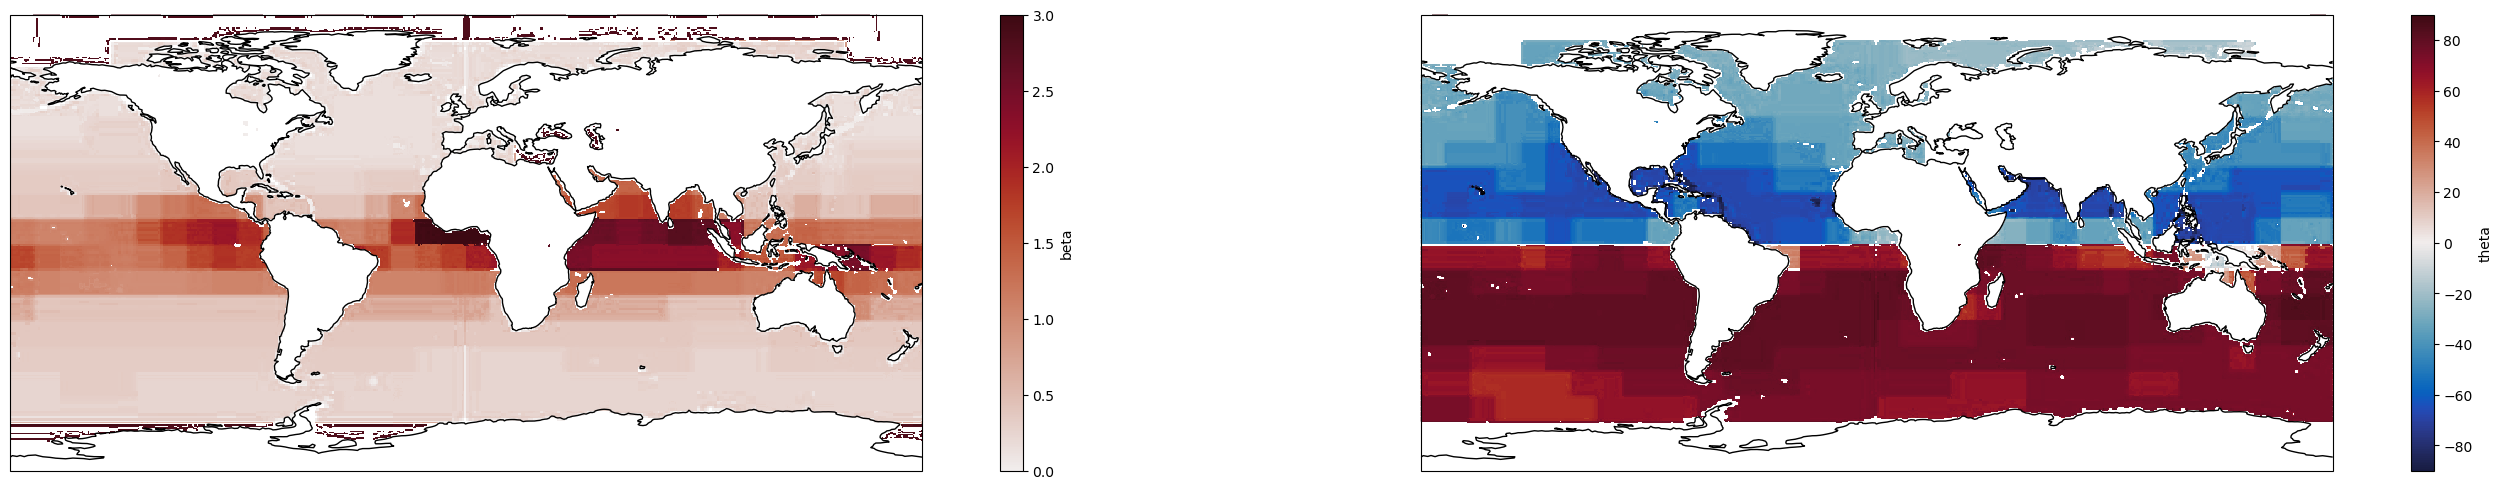

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5), subplot_kw={"projection": ccrs.PlateCarree()})

beta_da.plot(ax=ax1, cmap=cmo.amp, vmin=0, vmax=3)
ax1.coastlines()

theta_da.plot(ax=ax2, cmap=cmo.balance, vmin=-90, vmax=90)
ax2.coastlines()

fig.tight_layout()
plt.show()

In [6]:
out_grid = xe.util.grid_global(4.0, 4.0, cf=True)
regridder = xe.Regridder(beta_da, out_grid, method="nearest_s2d")

In [7]:
beta_da = regridder(beta_da)
theta_da = regridder(theta_da)

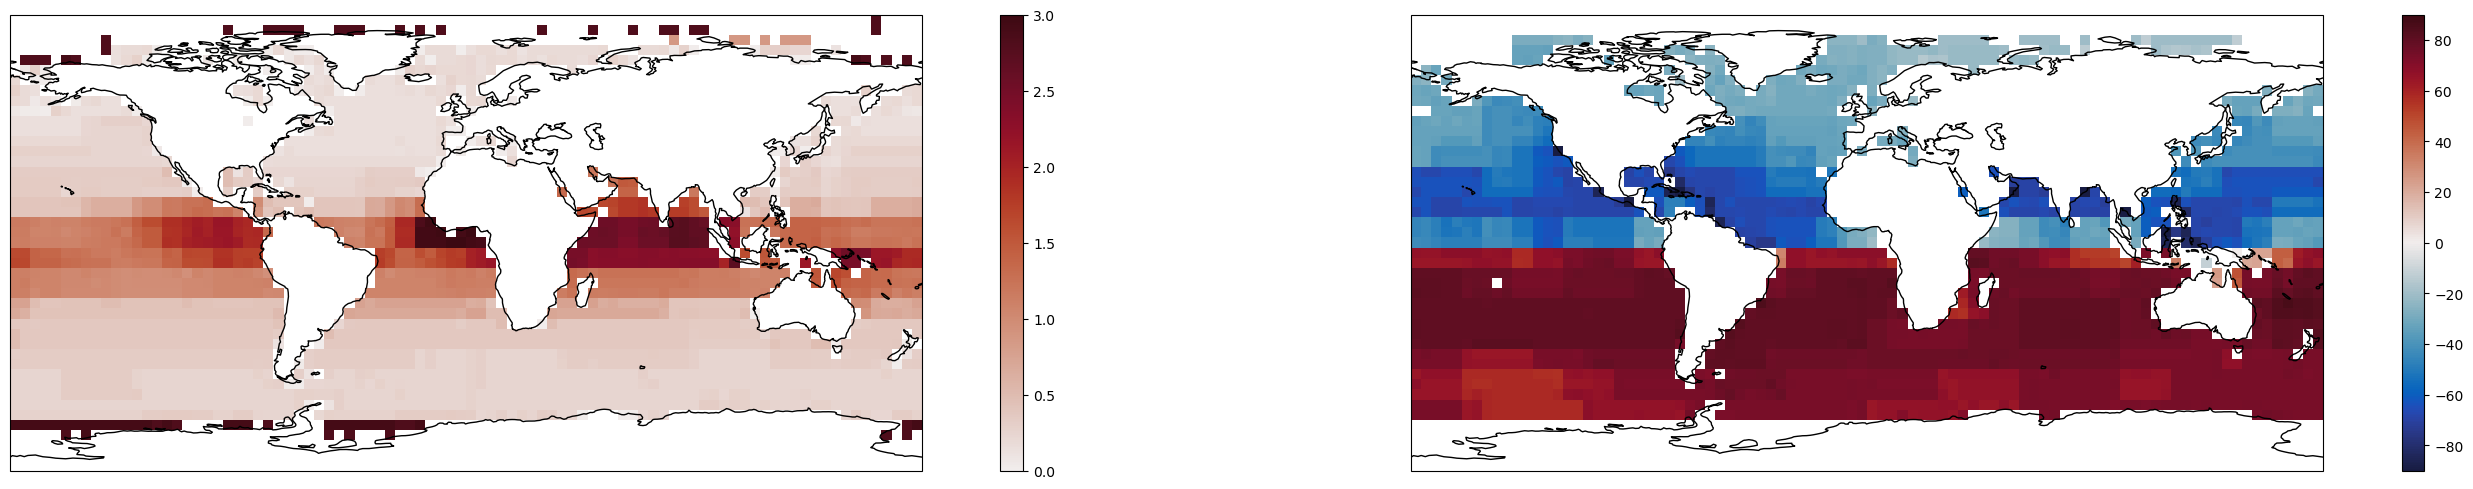

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5), subplot_kw={"projection": ccrs.PlateCarree()})

beta_da.plot(ax=ax1, cmap=cmo.amp, vmin=0, vmax=3)
ax1.coastlines()

theta_da.plot(ax=ax2, cmap=cmo.balance, vmin=-90, vmax=90)
ax2.coastlines()

fig.tight_layout()
plt.show()

In [9]:
beta_da = beta_da.where(~((beta_da > 0.5) & (np.abs(beta_da.lat) > 60)))
alpha_da = beta_da * np.exp(1j * np.deg2rad(theta_da))

beta_da = xr.DataArray(
    np.abs(alpha_da),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)
theta_da = xr.DataArray(
    np.angle(alpha_da, deg=True),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)

In [10]:
alpha_da.to_zarr("data/rio_2014/alpha.zarr", mode="w")

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/zarr/api/asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [11]:
beta_da = xr.DataArray(
    jnp.abs(alpha_da.values),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)
theta_da = xr.DataArray(
    jnp.angle(alpha_da.values, deg=True),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)

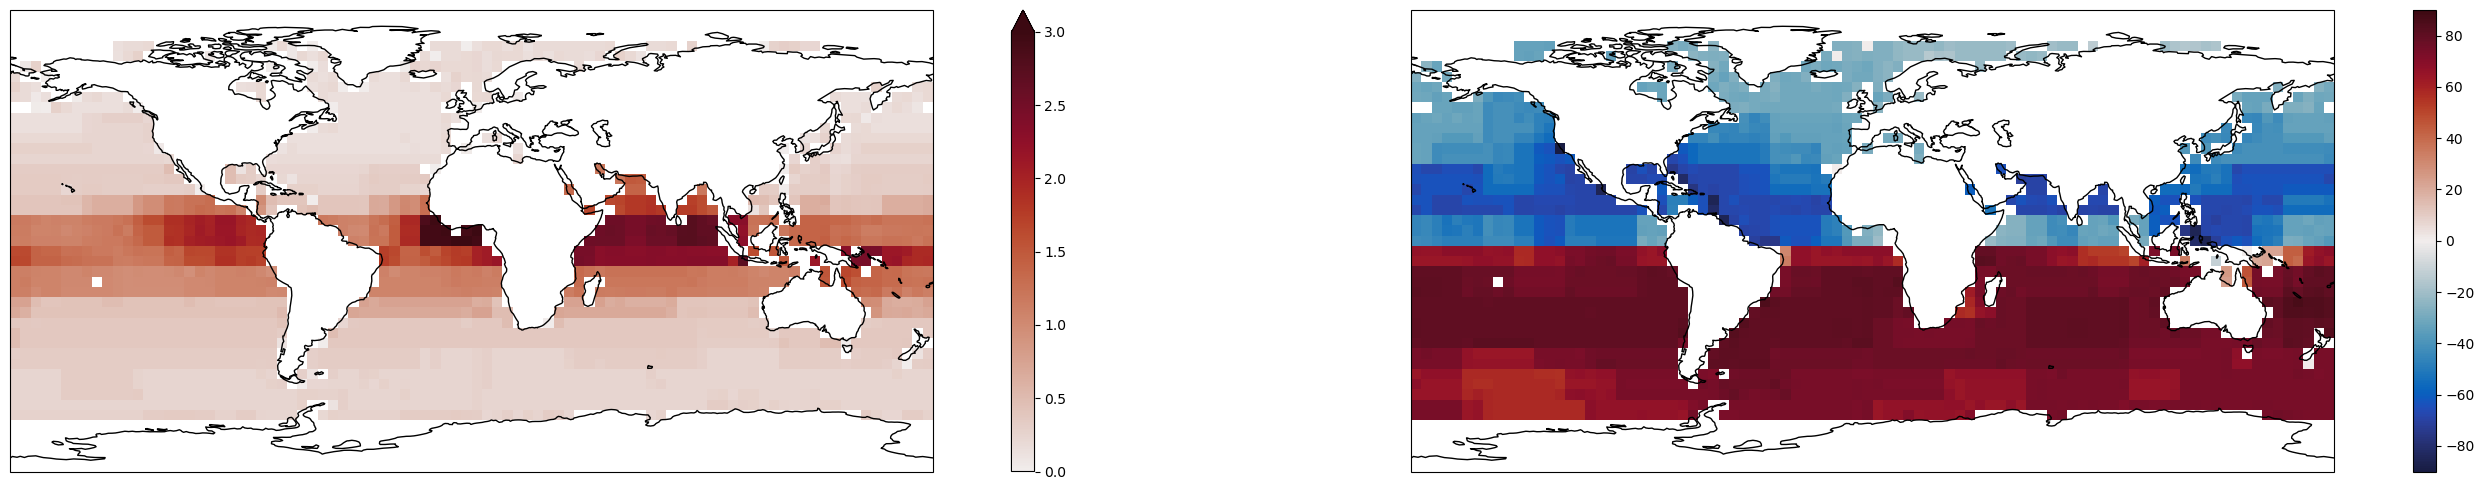

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5), subplot_kw={"projection": ccrs.PlateCarree()})

beta_da.plot(ax=ax1, cmap=cmo.amp, vmin=0, vmax=3)
ax1.coastlines()

theta_da.plot(ax=ax2, cmap=cmo.balance, vmin=-90, vmax=90)
ax2.coastlines()

fig.tight_layout()
plt.show()

### 2. Fit spherical harmonics coefficients to the regridded data

In [ ]:
# Spherical harmonics setup

lmax = 128

n_coeffs = (lmax + 1) ** 2
idx = jnp.arange(n_coeffs)

L = jnp.repeat(jnp.arange(lmax + 1), 2 * jnp.arange(lmax + 1) + 1)
M = idx - L * (L + 1)

def get_sph_harm_bases(lat, lon):
    lat = jnp.deg2rad(lat)
    lon = jnp.deg2rad(lon)
    colat = jnp.pi / 2 - lat
    phi = lon % (2 * jnp.pi)

    legendre = gen_associated_legendre(lmax, colat, is_normalized=True)

    Y = jax.vmap(
        lambda l, m: sph_harm_y(l, m, colat, phi, n_max=lmax, legendre=legendre)
    )(L, M).T

    return Y

In [44]:
alpha_da = xr.open_zarr("data/rio_2014/alpha.zarr")["__xarray_dataarray_variable__"]

In [45]:
beta_da = xr.DataArray(
    jnp.abs(alpha_da.values),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)
theta_da = xr.DataArray(
    jnp.angle(alpha_da.values, deg=True),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)

In [46]:
lat = alpha_da.lat.values
lon = alpha_da.lon.values

lat2d, lon2d = jnp.meshgrid(lat, lon, indexing="ij")

lat_flat = lat2d.ravel()
lon_flat = lon2d.ravel()

alpha_flat = alpha_da.values.ravel()

In [47]:
valid_mask_flat = jnp.isfinite(alpha_flat)

lat_flat_valid = lat_flat[valid_mask_flat]
alpha_flat_valid = alpha_flat[valid_mask_flat]

Y_flat = get_sph_harm_bases(lat_flat, lon_flat)
Y_flat_valid = get_sph_harm_bases(lat_flat_valid, lon_flat[valid_mask_flat])
Y_flat_nan = get_sph_harm_bases(lat_flat[~valid_mask_flat], lon_flat[~valid_mask_flat])

In [48]:
alphas = jnp.linalg.lstsq(Y_flat_valid, alpha_flat_valid, rcond=None)[0]

In [49]:
final_loss = jnp.mean(jnp.abs(alpha_flat_valid - Y_flat_valid @ alphas) ** 2)
print(f"Final loss: {final_loss:.4e}")

Final loss: 1.0163e-28


In [50]:
alpha_fit_flat = Y_flat @ alphas
alpha_fit_lstsq = alpha_fit_flat.reshape(alpha_da.shape)

In [51]:
beta_fit_lstsq_da = xr.DataArray(
    jnp.abs(alpha_fit_lstsq),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)
theta_fit_lstsq_da = xr.DataArray(
    jnp.angle(alpha_fit_lstsq, deg=True),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)

In [52]:
# Loss function: mean squared error


def loss_fun(alpha_coeffs, args):
    (lat_valid, Y_valid, Y_nan), y = args

    alpha_valid = Y_valid @ alpha_coeffs

    residuals = jnp.abs(y - alpha_valid) ** 2
    loss = jnp.mean(residuals)

    return loss


val_grad_loss_fun = jax.jit(jax.value_and_grad(loss_fun))

In [53]:
# Do optimization

solver = jaxopt.LBFGS(fun=val_grad_loss_fun, value_and_grad=True)
sol = solver.run(
    init_params=jnp.full((n_coeffs,), 1 + 1j * 0),
    args=((lat_flat_valid, Y_flat_valid, Y_flat_nan), alpha_flat_valid)
)

print(f"Solve took {sol.state.iter_num} iterations, final loss = {sol.state.value:.4e}")

Solve took 59 iterations, final loss = 3.0235e-04


In [54]:
alpha_fit_flat = Y_flat @ sol.params
alpha_fit_lbfgs = alpha_fit_flat.reshape(alpha_da.shape)

In [55]:
beta_fit_lbfgs_da = xr.DataArray(
    jnp.abs(alpha_fit_lbfgs),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)
theta_fit_lbfgs_da = xr.DataArray(
    jnp.angle(alpha_fit_lbfgs, deg=True),
    coords=alpha_da.coords,
    dims=alpha_da.dims,
)

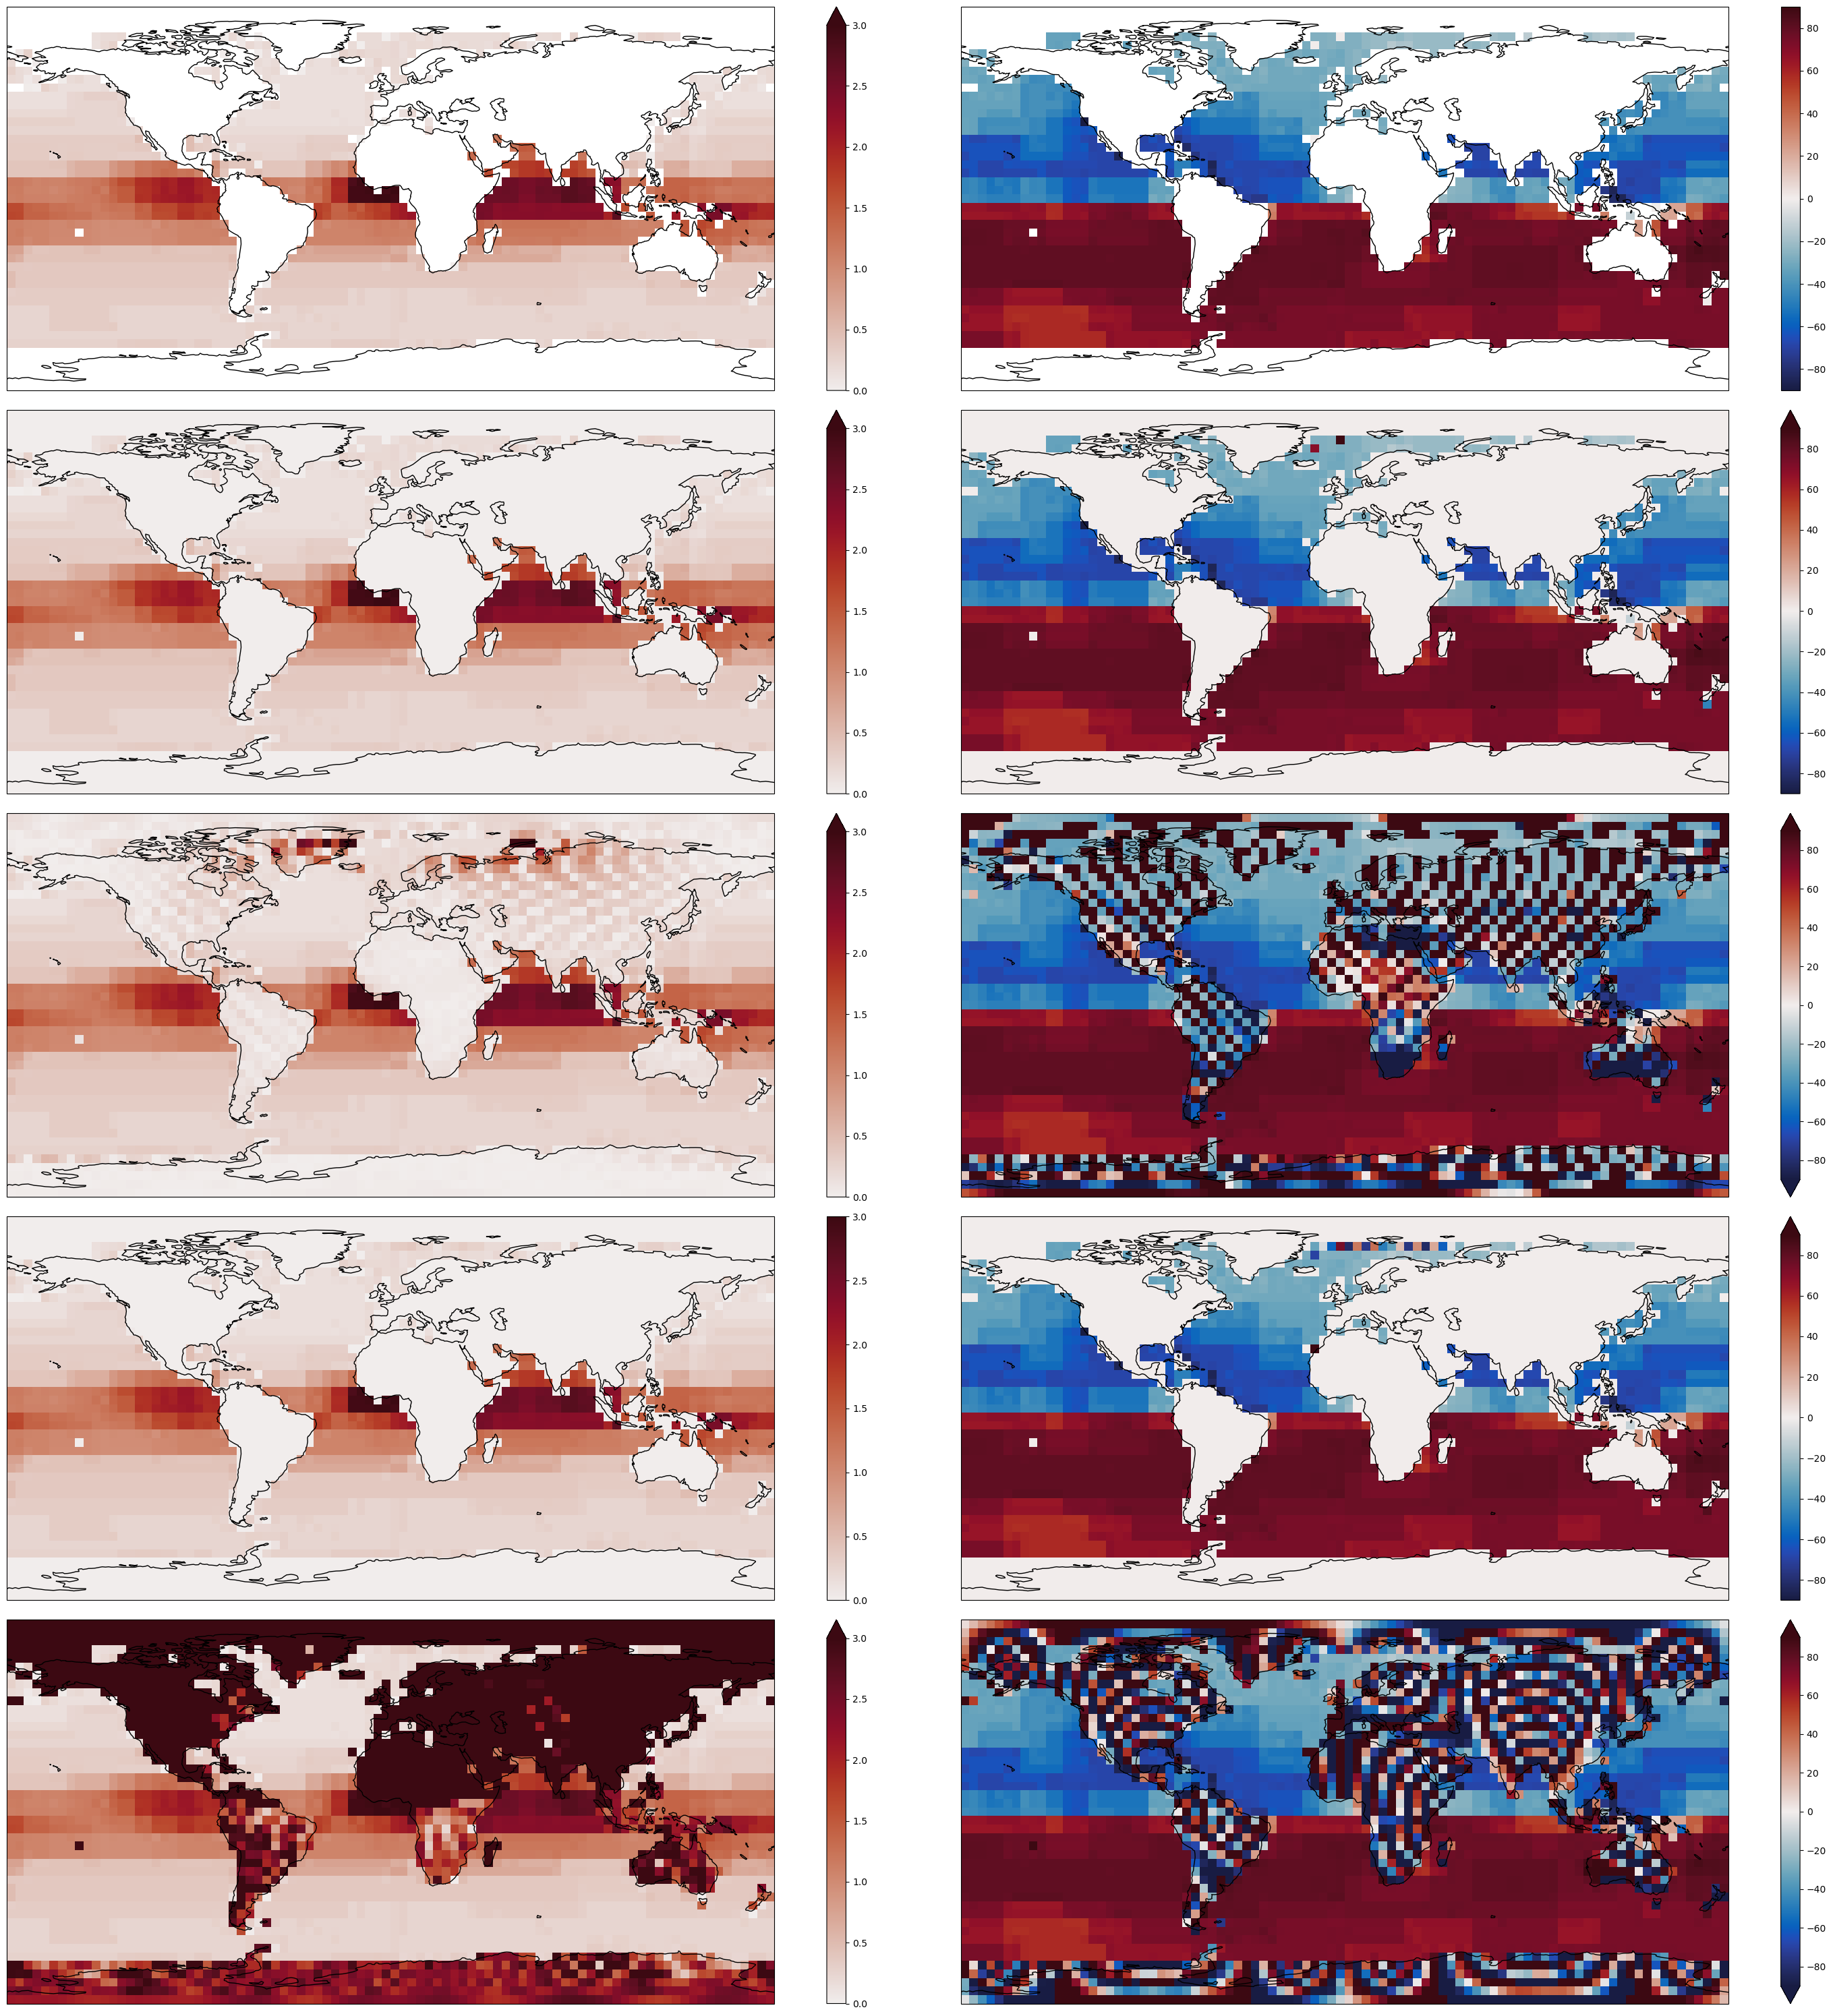

In [56]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(
    5, 2, figsize=(30, 30), subplot_kw={"projection": ccrs.PlateCarree()}
)

beta_da.plot(ax=ax1, cmap=cmo.amp, vmin=0, vmax=3)
ax1.coastlines()

theta_da.plot(ax=ax2, cmap=cmo.balance, vmin=-90, vmax=90)
ax2.coastlines()

(beta_fit_lstsq_da * ~np.isnan(beta_da)).plot(ax=ax3, cmap=cmo.amp, vmin=0, vmax=3)
ax3.coastlines()

(theta_fit_lstsq_da * ~np.isnan(theta_da)).plot(ax=ax4, cmap=cmo.balance, vmin=-90, vmax=90)
ax4.coastlines()

beta_fit_lstsq_da.plot(ax=ax5, cmap=cmo.amp, vmin=0, vmax=3)
ax5.coastlines()

theta_fit_lstsq_da.plot(ax=ax6, cmap=cmo.balance, vmin=-90, vmax=90)
ax6.coastlines()

(beta_fit_lbfgs_da * ~np.isnan(beta_da)).plot(ax=ax7, cmap=cmo.amp, vmin=0, vmax=3)
ax7.coastlines()

(theta_fit_lbfgs_da * ~np.isnan(theta_da)).plot(ax=ax8, cmap=cmo.balance, vmin=-90, vmax=90)
ax8.coastlines()

beta_fit_lbfgs_da.plot(ax=ax9, cmap=cmo.amp, vmin=0, vmax=3)
ax9.coastlines()

theta_fit_lbfgs_da.plot(ax=ax10, cmap=cmo.balance, vmin=-90, vmax=90)
ax10.coastlines()

fig.tight_layout()
plt.show()